# Plot example geophone and hydrophone spectrograms computed using STFT for the 3 components of a list of stations

In [19]:
# Imports
from os.path import join
from matplotlib.pyplot import subplots
from matplotlib.dates import DateFormatter
from matplotlib.dates import MinuteLocator, SecondLocator
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator
from pandas import Timestamp, Timedelta
from numpy import log10

from utils_basic import ROOTDIR_HYDRO, ROOTDIR_GEO, GEO_COMPONENTS, VELOCITY_UNIT, days_to_timestamps, save_figure
from utils_preproc import read_and_process_windowed_geo_waveforms, read_and_process_windowed_hydro_waveforms
from utils_spec import get_spectrogram_stft

In [20]:
# Inputs
## Data
starttime = Timestamp("2020-01-13T18:36:00Z")
#hydro_station_to_plot = "A00"
hydro_station_to_plot = "B00"
#geo_stations_to_plot = ["A01", "A04", "A08", "A11", "A15", "A19"]
geo_stations_to_plot = ["B01", "B04", "B08", "B11", "B19", "B20"]
locations_to_plot = ["01", "02", "03", "04", "05", "06"]

dur = 780.0 # seconds
window_length = 2.0 # seconds

rootdir_hydro = ROOTDIR_HYDRO
rootdir_geo = ROOTDIR_GEO

## Plotting
ylim_pres = (-0.5, 0.5)
ylim_vel = (-300.0, 300.0)
ylim_freq = (0.0, 250)

dbmin_geo = -60.0
dbmax_geo = 0.0

dbmin_hydro = -80.0
dbmax_hydro = 0.0

linewidth_wf = 0.5

linewidth_box = 1.5

xdim_ax = 7.5
ydim_ax = 2.5

plot_box = False

timemin_box = Timestamp("2020-01-13T19:36:20Z")
timemax_box = Timestamp("2020-01-13T19:36:35Z")

freqmin_box = 60.0
freqmax_box = 120.0

major_locator = MinuteLocator(interval=2)
minor_locator = SecondLocator(interval=30)

In [21]:
# Read the geophone and hydrophone waveforms
stream_hydro = read_and_process_windowed_hydro_waveforms(starttime, dur, stations=hydro_station_to_plot, locations=locations_to_plot)
stream_geo = read_and_process_windowed_geo_waveforms(starttime, dur, stations=geo_stations_to_plot)

In [22]:
# Compute the spectrograms

## Hydrophone
specdict_hydro = {}

for location in locations_to_plot:
    try:
        trace = stream_hydro.select(location=location)[0]
        data = trace.data
        samprat = trace.stats.sampling_rate
        freqax, timeax, spec = get_spectrogram_stft(data, window_length=window_length, overlap=0.5)
    except IndexError:
        print(f"No data for {hydro_station_to_plot}.{location}")
        freqax, timeax, spec = None, None, None

    specdict_hydro[(hydro_station_to_plot, location)] = (freqax, timeax, spec)

## Geophone
specdict_geo = {}

for station in geo_stations_to_plot:
    for component in GEO_COMPONENTS:
        trace = stream_geo.select(station=station, component=component)[0]
        data = trace.data
        samprat = trace.stats.sampling_rate

        freqax, timeax, spec = get_spectrogram_stft(data, window_length=window_length, overlap=0.5)

        specdict_geo[(station, component)] = (freqax, timeax, spec)

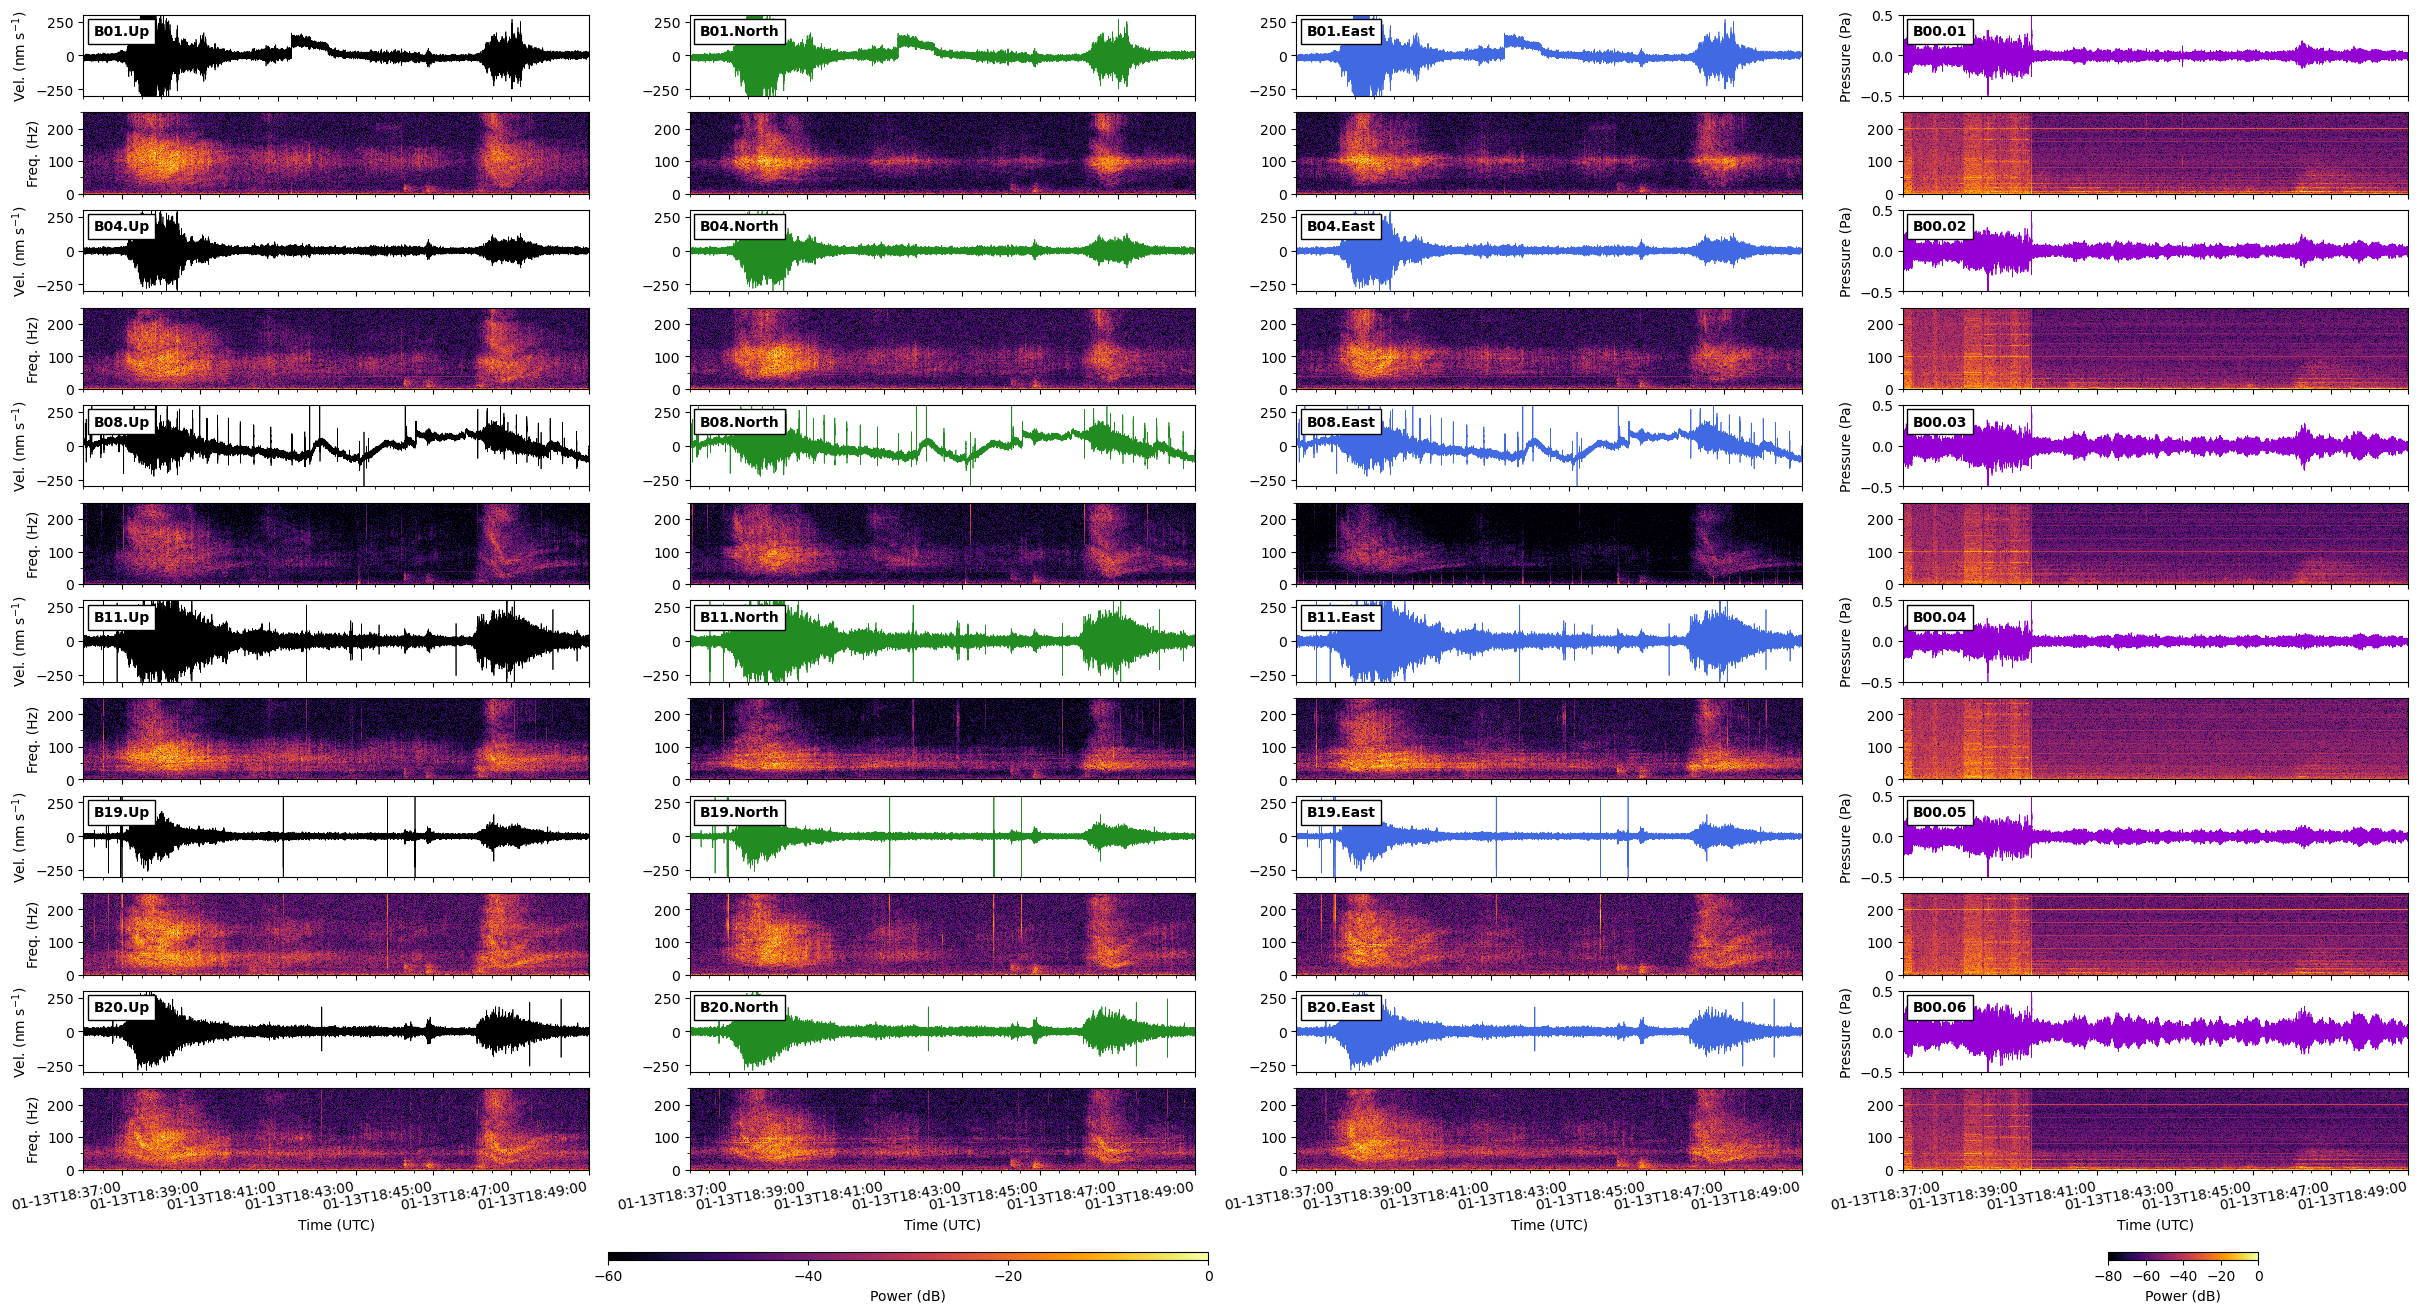

In [23]:
# Plot the waveforms and spectrograms

## Check if the number of hydrophone locations is the same as the number of geophone stations
if len(geo_stations_to_plot) != len(locations_to_plot):
    raise ValueError("The number of hydrophone locations must be the same as the number of geophone stations")

## Create the figure
numgeo = len(geo_stations_to_plot)
numrow = len(geo_stations_to_plot)
numcol = 4

fig, axes = subplots(2 * numrow, numcol, figsize=(xdim_ax * numcol, ydim_ax * numrow), sharex=True)

for i in range(numgeo):
    for j in range(numcol):

        ## Plot the waveforms
        ax = axes[2 * i, j]

        if j < len(GEO_COMPONENTS):
            component_to_plot = GEO_COMPONENTS[j]

            station = geo_stations_to_plot[i]
            trace = stream_geo.select(station=station, component=component)[0]
            data = trace.data
            timeax_wf = trace.times("matplotlib")
            timeax_wf = days_to_timestamps(timeax_wf)

            if component_to_plot == "Z":
                ax.plot(timeax_wf, data, "black", linewidth=linewidth_wf)
                label = "Up"
            elif component_to_plot == "1":
                ax.plot(timeax_wf, data, "forestgreen", linewidth=linewidth_wf)
                label = "North"
            elif component_to_plot == "2":
                ax.plot(timeax_wf, data, "royalblue", linewidth=linewidth_wf)
                label = "East"

            ax.set_ylim(ylim_vel)
            ax.text(0.02, 0.88, f"{station}.{label}", transform=ax.transAxes, va="top", ha="left", fontsize=10, fontweight="bold", bbox=dict(facecolor="white", alpha=1.0))

            if j == 0:
                ax.set_ylabel(f"Vel. ({VELOCITY_UNIT})")
        else:
            station = hydro_station_to_plot
            location = locations_to_plot[i]

            try:
                trace = stream_hydro.select(station=station, location=location)[0]
                data = trace.data
                timeax_wf = trace.times("matplotlib")
                timeax_wf = days_to_timestamps(timeax_wf)

                ax.plot(timeax_wf, data, "darkviolet", linewidth=linewidth_wf)
            except IndexError:
                print(f"No data for {station}.{location}")
                
            ax.set_ylim(ylim_pres)
            ax.text(0.02, 0.88, f"{station}.{location}", transform=ax.transAxes, va="top", ha="left", fontsize=10, fontweight="bold", bbox=dict(facecolor="white", alpha=1.0))

            ax.set_ylabel("Pressure (Pa)")

        ## Plot the spectrograms
        ax = axes[2 * i + 1, j]

        if j < len(GEO_COMPONENTS):
            component_to_plot = GEO_COMPONENTS[j]

            station = geo_stations_to_plot[i]
            freqax, timeax_spec, spec = specdict_geo[(station, component_to_plot)]
            timeax_spec = [timeax_wf[0] + Timedelta(seconds=t) for t in timeax_spec]
            cmap_geo = ax.pcolormesh(timeax_spec, freqax, spec, cmap="inferno", vmin=dbmin_geo, vmax=dbmax_geo)

            if plot_box:
                box = Rectangle((timemin_box, freqmin_box), timemax_box - timemin_box, freqmax_box - freqmin_box, linewidth=linewidth_box, edgecolor="limegreen", facecolor="none")
                ax.add_patch(box)

            ax.set_ylim(ylim_freq)

            if j == 0:
                ax.set_ylabel("Freq. (Hz)")

            if i == numgeo - 1:
                ax.set_xlabel("Time (UTC)")
                ax.xaxis.set_major_formatter(DateFormatter("%m-%dT%H:%M:%S"))

                for tick in ax.get_xticklabels():
                    tick.set_horizontalalignment("right")
                    tick.set_verticalalignment("top")
                    tick.set_rotation(10)

        else:
            location = locations_to_plot[i]
            freqax, timeax_spec, spec = specdict_hydro[(hydro_station_to_plot, location)]

            if freqax is not None:
                timeax_spec = [timeax_wf[0] + Timedelta(seconds=t) for t in timeax_spec]
                cmap_hydro = ax.pcolormesh(timeax_spec, freqax, spec, cmap="inferno", vmin=dbmin_hydro, vmax=dbmax_hydro)

            if plot_box:
                box = Rectangle((timemin_box, freqmin_box), timemax_box - timemin_box, freqmax_box - freqmin_box, linewidth=linewidth_box, edgecolor="limegreen", facecolor="none")
                ax.add_patch(box)


            ax.set_ylim(ylim_freq)

            if j == 0:
                ax.set_ylabel("Freq. (Hz)")

            if i == numgeo - 1:
                ax.set_xlabel("Time (UTC)")
                ax.xaxis.set_major_formatter(DateFormatter("%m-%dT%H:%M:%S"))

                for tick in ax.get_xticklabels():
                    tick.set_horizontalalignment("right")
                    tick.set_verticalalignment("top")
                    tick.set_rotation(10)

        # Set Y-axis ticks
        ax.yaxis.set_major_locator(MultipleLocator(100))
        ax.yaxis.set_minor_locator(MultipleLocator(50))

# Set X-axis ticks
ax = axes[0, 0]
ax.set_xlim(starttime, starttime + Timedelta(seconds=dur))
ax.xaxis.set_major_formatter(DateFormatter("%m-%dT%H:%M:%S"))
ax.xaxis.set_major_locator(major_locator)
ax.xaxis.set_minor_locator(minor_locator)


# Add a horizontal colorbar for the geophone spectrograms
cax = fig.add_axes([0.3, 0.05, 0.2, 0.005])  # [left, bottom, width, height]
cbar = fig.colorbar(cmap_geo, cax=cax, orientation='horizontal', label="Power (dB)")
cbar.locator = MultipleLocator(10)
cbar.update_ticks()

# Add a horizontal colorbar for the hydrophone spectrograms
cax = fig.add_axes([0.8, 0.05, 0.05, 0.005])  # [left, bottom, width, height]
fig.colorbar(cmap_hydro, cax=cax, orientation='horizontal', label="Power (dB)", ticks=[-80, -60, -40, -20, 0])
cbar.locator = MultipleLocator(20)
cbar.update_ticks()



In [24]:
# Save the figure
timestr = starttime.strftime("%Y-%m-%d-%H-%M-%S")

subarray = hydro_station_to_plot[0]
figname = f"hydro_and_geo_spectrogram_stft_{timestr}_dur{dur:.0f}s_{subarray}.png"

save_figure(fig, figname)

Figure saved to /Volumes/OmanData/data/hydro_and_geo_spectrogram_stft_2020-01-13-18-36-00_dur780s_B.png
